In [1]:
from ngboost import NGBRegressor
from ngboost.scores import LogScore, CRPScore

In [2]:
def ngb_kfold_reg(X_train, y_train, split, bayes_opt=True,
                  distribution='normal', learning_rate=0.01,
                  minibatch_frac=1.0, n_estimators=500,
                  max_depth=6, min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0):
    seed = 8982
    params = {'learning_rate': learning_rate,
              'minibatch_frac': minibatch_frac,
              'n_estimators': n_estimators,
              'natural_gradient':True,
              'random_state': seed,
              'verbose': True,
              'verbose_eval': 200}

    if distribution == 'normal':
        from ngboost.distns import Normal
        ngb = NGBRegressor(Dist=Normal, Score=LogScore, **params)
    elif distribution == 'lognormal':
        from ngboost.distns import LogNormal
        ngb = NGBRegressor(Dist=LogNormal, Score=LogScore, **params)
    elif distribution == 'exponential':
        from ngboost.distns import Exponential
        ngb = NGBRegressor(Dist=Exponential, Score=LogScore, **params)
    
    n_splits = len(split)
    oofs = np.zeros(X_train.shape[0])
    models = []; valid_score = []
    dist_df = pd.DataFrame()
    feature_importance_df = pd.DataFrame()
    
    print(f'========== NGBoost Regressor training on : {X_train.shape} ==========')
    for i, (train_idx, valid_idx) in enumerate(split):
        print(f'========== NGBoost Regressor training: {i+1}/{n_splits} fold ==========')
        model = ngb.fit(X_train.iloc[train_idx,:], y_train[train_idx],
                           X_val=X_train.iloc[valid_idx,:], Y_val=y_train[valid_idx],
                           early_stopping_rounds=20)
        models.append(model)
        oofs[valid_idx] = model.predict(X_train.iloc[valid_idx,:], max_iter=model.best_val_loss_itr)
        dist_param = model.pred_dist(X_train.iloc[valid_idx,:]).params
        #valid_score.append(model.val_loss)
        
        # Distribution Params
        fold_dist_df = pd.DataFrame()
        for k in dist_param.keys():
            fold_dist_df[f'~dist({k})'] = dist_param[k]
        fold_dist_df['fold'] = i+1
        dist_df = pd.concat([dist_df, fold_dist_df], axis=0)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = common_cols + category_cols
        #fold_importance_df['importance_loc'] = model.feature_importances_[0]
        #fold_importance_df['importance_scale'] = model.feature_importances_[1]
        fold_importance_df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        del fold_importance_df, fold_dist_df, dist_param; gc.collect()
    
    #print('====================')
    #print(f'CV AVG: {metric} - {np.mean(valid_score)}')
    #print(f'CV STD: {metric} - {np.std(valid_score)}')
    #print('====================')

    if bayes_opt:
        return valid_avg_score
    else:
        return oofs, models, feature_importance_df, dist_df

In [3]:
def ngb_pred_reg(X_test, models):
    y_test_total = 0
    for i, model in enumerate(models):
        print(f'NGBoost Predicting on {i}-th model')
        y_test = model.predict(X_test, max_iter=model.best_val_loss_itr)
        y_test_total += y_test
    y_test_total /= len(models)
    return y_test_total

In [4]:
from ngboost import NGBClassifier
from ngboost.scores import LogScore

In [5]:
def ngb_kfold_clf(X_train, y_train, split, bayes_opt=True,
                  objective='binary', learning_rate=0.01,
                  minibatch_frac=1.0, n_estimators=500,
                  max_depth=6, min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0):
    seed = 8982
    params = {'learning_rate': learning_rate,
              'minibatch_frac': minibatch_frac,
              'n_estimators': n_estimators,
              'natural_gradient':True,
              'random_state': seed,
              'verbose': True,
              'verbose_eval': 200}
    if objective == 'binary':
        from ngboost.distns import Bernoulli
        ngb = NGBClassifier(Dist=Bernoulli, Score=LogScore, **params)
    elif objective == 'multiclass':
        from ngboost.distns import k_categorical
        ngb = NGBClassifier(Dist=k_categorical(3), Score=LogScore, **params)
    
    n_splits = len(split)
    oofs = np.zeros(X_train.shape[0])
    models = []; valid_score = []
    dist_df = pd.DataFrame()
    feature_importance_df = pd.DataFrame()
    
    print(f'========== NGBoost Classifier training on : {X_train.shape} ==========')
    for i, (train_idx, valid_idx) in enumerate(split):
        print(f'========== NGBoost Classifier training: {i+1}/{n_splits} fold ==========')
        model = ngb.fit(X_train.iloc[train_idx,:], y_train[train_idx],
                        X_val=X_train.iloc[valid_idx,:], Y_val=y_train[valid_idx],
                        early_stopping_rounds=20)
        models.append(model)
        oofs[valid_idx] = model.predict_proba(X_train.iloc[valid_idx,:], max_iter=model.best_val_loss_itr)[:,1]
        dist_param = model.pred_dist(X_train.iloc[valid_idx,:]).params
        #valid_score.append(model.val_loss)
        
        # Bernoulli
        fold_dist_df = pd.DataFrame()
        for k in dist_param.keys():
            fold_dist_df[f'P(y={k}|x)'] = dist_param[k]
        fold_dist_df['fold'] = i+1
        dist_df = pd.concat([dist_df, fold_dist_df], axis=0)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = common_cols + category_cols
        fold_importance_df['importance_loc'] = model.feature_importances_[0]
        #fold_importance_df['importance_scale'] = model.feature_importances_[1]
        fold_importance_df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        del fold_importance_df, fold_dist_df, dist_param; gc.collect()
    
    #print('====================')
    #print(f'CV AVG: {metric} - {np.mean(valid_score)}')
    #print(f'CV STD: {metric} - {np.std(valid_score)}')
    #print('====================')

    if bayes_opt:
        return valid_avg_score
    else:
        return oofs, models, feature_importance_df, dist_df

In [6]:
"""
    #For instance, to get the predictions on the first 5 examples after fitting 415 base learners, use:
    preds = ngb_cls.staged_predict(X_cls_test)
    preds[415][0:5]
    #array([1, 0, 1, 1, 1])
"""

'\n    #For instance, to get the predictions on the first 5 examples after fitting 415 base learners, use:\n    preds = ngb_cls.staged_predict(X_cls_test)\n    preds[415][0:5]\n    #array([1, 0, 1, 1, 1])\n'

In [7]:
def ngb_pred_clf(X_test, models, threshold):
    y_test_soft_total = 0; y_test_hard_total = 0
    for i, model in enumerate(models):
        print(f'NGBoost Predicting on {i}-th model')
        y_test = model.predict_proba(X_test, max_iter=model.best_val_loss_itr)[:,1]
        y_test_soft_total += y_test
        y_test = model.predict(X_test, max_iter=model.best_val_loss_itr)
        y_test_hard_total += y_test
    y_test_soft_total /= len(models)
    y_test_soft = np.where(y_test_soft_total > threshold, 1, 0)
    y_test_hard_total /= len(models)
    
    if (y_test_soft != y_test_hard_total).sum() > 0:
        print('Different thresholds with NGB and arbitrary')
    return y_test_soft, y_test_hard_total
# returns: threshold, ngb hard predict

In [8]:
import pandas as pd
import numpy as np
import gc

In [9]:
x = pd.DataFrame(np.random.randn(300), columns=['gauss'])
x['mean4'] = np.random.randn(300)+4
x['std4'] = np.random.randn(300)*4
x['target'] = np.where((x['mean4'] <= 4) & (x['std4'] >= 0), int(1), int(0))

In [10]:
x.head(7)

,gauss,mean4,std4,target
0,-0.121990,3.922068,3.292999,1
1,0.313014,5.311866,4.187469,0
2,-0.346650,4.807992,2.598584,0
3,-1.682090,3.993283,0.249756,1
4,-1.653344,3.739459,-0.322117,0
5,-1.662581,3.715552,3.145790,1
6,-0.115491,2.522127,-7.036124,0


In [11]:
x[x.target == 0].mean4.plot.hist(bins=30)
x[x.target == 1].mean4.plot.hist(bins=15)

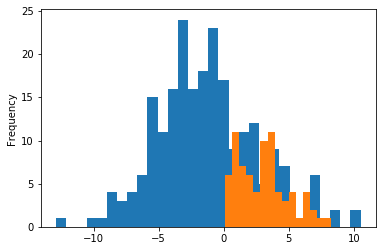

In [12]:
x[x.target == 0].std4.plot.hist(bins=30)
x[x.target == 1].std4.plot.hist(bins=15)

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=False)
train_idx, valid_idx = kf.split(x)
split = [train_idx, valid_idx]
split[0][1][:5]

array([0, 1, 2, 3, 4])

In [14]:
common_cols = list(set(x.columns) - {'target'})
category_cols = []
X_train = x[common_cols]
y_train = x.target.astype(np.int8).values
#y_train = y_train.reshape(300,1)#.transpose()

common_cols

['std4', 'gauss', 'mean4']

In [15]:
print(y_train.shape)
y_train[:5]

(300,)


array([1, 0, 0, 1, 0], dtype=int8)

In [16]:
oofs, models, fimp, dist = ngb_kfold_clf(X_train, y_train, split, objective='binary', bayes_opt=False)

========== NGBoost Classifier training on : (300, 3) ==========
========== NGBoost Classifier training: 1/2 fold ==========
[iter 0] loss=0.5269 val_loss=0.5810 scale=2.0000 norm=4.0000
== Early stopping achieved.
== Best iteration / VAL 88 (val_loss=0.1083)
========== NGBoost Classifier training: 2/2 fold ==========
[iter 0] loss=0.1070 val_loss=0.0088 scale=1.0000 norm=3.6710
== Early stopping achieved.
== Best iteration / VAL 60 (val_loss=0.0017)


In [17]:
from sklearn.metrics import f1_score
threshold = 0.5
np.sqrt(f1_score(y_train, np.where(oofs > threshold, 1, 0)))

0.989743318610787

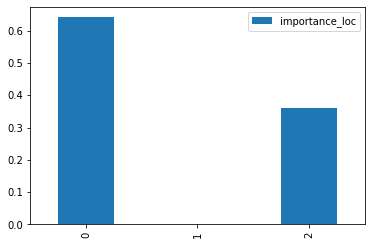

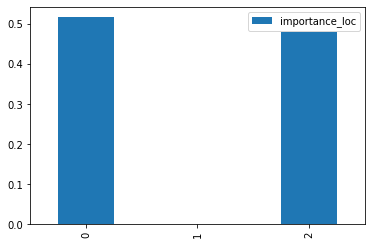

In [18]:
for i in fimp.fold.unique():
    fimp.loc[fimp.fold == i][['feature', 'importance_loc']].plot.bar()

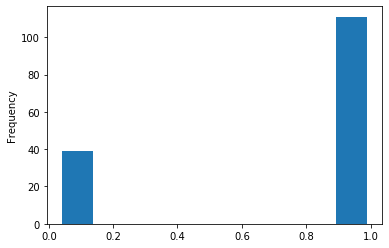

In [19]:
dist.loc[dist.fold == 1]['P(y=p0|x)'].plot.hist()

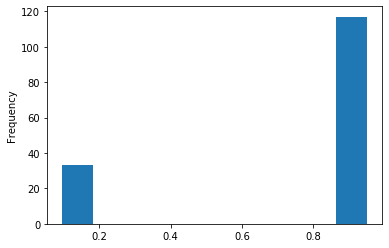

In [20]:
dist.loc[dist.fold == 2]['P(y=p0|x)'].plot.hist()

In [21]:
x = pd.DataFrame(np.random.randn(300), columns=['gauss'])
x['mean4'] = np.random.randn(300)+4
x['std4'] = np.random.randn(300)*4
x['target'] = np.where((x['mean4'] <= 4) & (x['std4'] >= 0), int(1), int(0))
x['target'] = x.gauss + np.random.randn(300) / 10
x.head()

,gauss,mean4,std4,target
0,1.767217,3.620850,-6.424217,1.599851
1,0.277485,5.409506,0.443056,0.484545
2,0.598812,3.774351,-0.672794,0.598019
3,0.691115,2.955959,4.137148,0.760281
4,-1.544173,4.087262,-4.931580,-1.616543


In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=False)
train_idx, valid_idx = kf.split(x)
split = [train_idx, valid_idx]
split[0][1][:5]

array([0, 1, 2, 3, 4])

In [23]:
common_cols = list(set(x.columns) - {'target'})
category_cols = []
X_train = x[common_cols]
y_train = x.target.astype(np.int8).values
#y_train = y_train.reshape(300,1)#.transpose()

common_cols

['std4', 'gauss', 'mean4']

In [24]:
oofs, models, fimp, dist = ngb_kfold_reg(X_train, y_train, split, distribution='normal', bayes_opt=False)

========== NGBoost Regressor training on : (300, 3) ==========
========== NGBoost Regressor training: 1/2 fold ==========
[iter 0] loss=0.9523 val_loss=0.9325 scale=1.0000 norm=0.8580
== Early stopping achieved.
== Best iteration / VAL 156 (val_loss=-0.3737)
========== NGBoost Regressor training: 2/2 fold ==========
[iter 0] loss=-0.3344 val_loss=-1.0815 scale=1.0000 norm=1.1674
== Early stopping achieved.
== Best iteration / VAL 163 (val_loss=-1.7561)


In [25]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, oofs))

0.15851672826976942

In [26]:
dist.head()

,~dist(loc),~dist(scale),fold
0,0.955125,0.240578,1
1,-0.000942,0.130168,1
2,-0.000942,0.130168,1
3,-0.000942,0.130168,1
4,-0.935657,0.249901,1


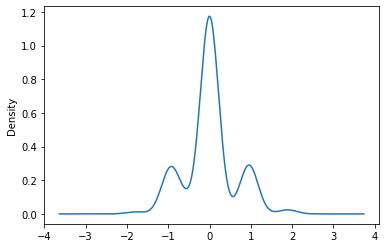

In [27]:
dist.loc[dist.fold == 1, '~dist(loc)'].plot.kde()

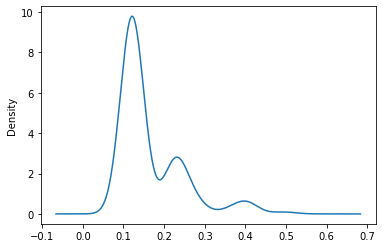

In [28]:
dist.loc[dist.fold == 2, '~dist(scale)'].plot.kde()